# Bayesian Optimisation Overview

1. General Overview
2. Gaussian Processes
3. Acquisition function
4. Example with GPy

General Overview

Bayesian Inference (Short)

GP - distributions over functions

> Sounds complicated, but only evaluated at a finite set of points
> Can be derived from Bayesian linear regression

> Theoretical description:

> Discuss Kernels;

> Samples from Priors;

> Noise free GP regression;

> Noisy GP regression;

> Acquisision function evaluation;

> Worked example with GPy;

## Gaussian Processes
https://www.cs.toronto.edu/~duvenaud/cookbook/

In [141]:
# Mu is assumed to be a zero function
# Kernel function 

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
    
def linear_kernel(x1,
                  x2,
                  sd = .1,
                  offset = -1.):
    """
    Linear kernel ref
    """
    return sd**2 * np.multiply.outer((x1-offset),(x2-offset))  

def squared_exponential_kernel(x1,
                               x2,
                               sd = 1.,
                               lengthscale = .1):
    """
    Squared exponential kernel ref
    """
    return sd**2 * np.exp(-(np.subtract.outer(x1,x2)**2)/(2*lengthscale**2))

def periodic_kernel(x1,
                    x2,
                    sd = 1.,
                    lengthscale = 1.,
                    period = 1.):
    """
    Periodic kernel ref
    """
    return sd**2 * np.exp(-2*(np.sin(np.pi*abs(np.subtract.outer(x1,x2))/period)**2)/(lengthscale**2))



def plot_kernel(kernel, domain_vals, params):
    """
    Visualise the kernel (matrix and )
    """

    plt.plot(domain_vals, kernel(domain_vals, np.zeros(len(domain_vals)), **params))
    plt.show()

    plt.imshow(kernel(domain_vals, domain_vals, **params))
    plt.show()

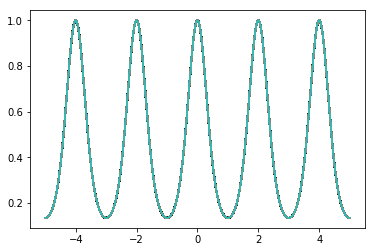

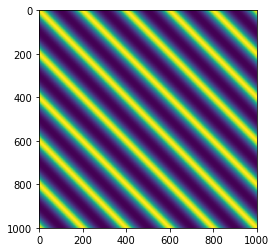

In [143]:
data = np.linspace(-5, 5, 1000)
plot_kernel(periodic_kernel, data, {"sd": 1., "lengthscale": 1., "period": 2.})

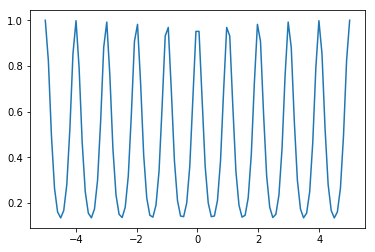

In [6]:
plt.plot(data,kernel_vals);plt.show()

In [156]:
def generate_gp(kernel, hyper_params, data, num_realisations):
    
    """
    Generate a series of draws from a GP to be used as prior
    """
    realisations = []
    data_dim = len(data)
    mean = np.zeros(data_dim)
    covariance = kernel(data, data, **hyper_params)
    realisations = np.random.multivariate_normal(mean, covariance, num_realisations)
    return realisations

realisations = generate_gp(periodic_kernel, { "sd": 1., "lengthscale": 1.}, data, 20)

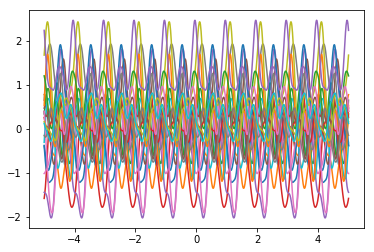

In [157]:
for realisation in realisations:
    plt.plot(data, realisation);
plt.show()

In [106]:
realisations[0][0]

array([-2.64449568, -0.76658173, -0.5285785 , -1.17095326, -0.05461899,
        0.43354756,  2.00286935,  1.48237493, -0.41581829,  0.23397807,
        0.75764429,  0.94728884,  0.55835786,  0.03463487,  0.41758464,
        0.7703603 ,  1.00908584,  0.53179518, -0.57226779, -0.76897644,
       -0.30099942, -0.26068411,  0.1131478 ,  1.04893487,  0.12618424,
       -2.26156442, -2.22298283,  0.40370577,  0.60139279, -0.45605809,
       -0.26499734, -0.33544279, -0.47262969,  0.16678675, -0.69642262,
        0.74475851,  0.83743738, -0.63767368, -0.15189434,  0.74520926,
        0.45281002, -0.92143284, -1.31764572, -0.56808349,  0.33127495,
        0.75420531,  2.07055721,  2.79301244,  2.37568274,  0.89970377,
        1.3976208 ,  1.06360262, -0.11831888, -0.86295499, -0.25624046,
       -0.22284469,  0.70805373,  0.14219291, -1.21084048, -1.19611204,
       -1.301181  , -1.92513923, -1.3878014 ,  0.17359929, -0.04994786,
       -0.1857328 ,  0.86344284,  0.78951707, -0.60486128, -0.95

In [267]:
#NF

def noise_free_posterior(kernel, hyper_params, data, num_realisations, eval_points, target_points):
    
    temp = np.dot(kernel(eval_points, data, **hyper_params), np.linalg.inv(kernel(data, data, **hyper_params)))
    
    
    mean = np.dot(temp, target_points.T)
    
    cov = kernel(eval_points, eval_points, **hyper_params) - np.dot(temp, kernel(data, eval_points, **hyper_params))
    
    post=np.random.multivariate_normal(mean.flatten(), cov, 1)
#     covariance = 
    return mean, cov, post

In [461]:
x_s = [1, 0.995995995996]
y_s = np.random.randn(len(x_s)) * 2
f_min = min(y_s)
mean,cov, post = noise_free_posterior(squared_exponential_kernel, {"sd": 1., "lengthscale": -1.}, np.array(x_s), 20, data, np.array(y_s))



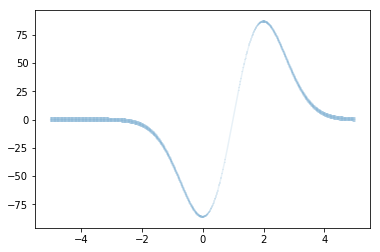

In [462]:
plt.errorbar(data, mean, yerr=np.sqrt(cov.diagonal())*1.96, alpha = .1);plt.show()


In [463]:
from scipy.stats import multivariate_normal
from scipy.stats import norm
var = cov.diagonal()

-1.7967967968


/Users/daniel.gradovich/anaconda/envs/lmd/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/Users/daniel.gradovich/anaconda/envs/lmd/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


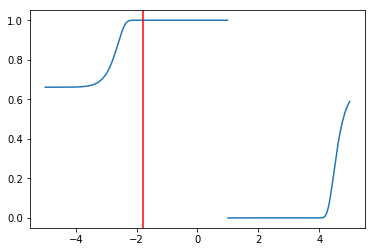

In [464]:
acq_ = [norm.cdf((f_min - m)/np.sqrt(v)) for m,v in zip(mean, var)]
largest_x = np.where(acq_ == max(acq_))[0][0]
print(data[largest_x])


plt.plot(data, [norm.cdf((f_min - m)/np.sqrt(v)) for m,v in zip(mean, var)]); 
plt.axvline(x = data[largest_x], c = 'r')
plt.show()



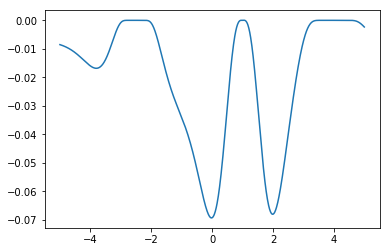

In [452]:
mu = [max(0, f_min - mean[i]) for i in range(len(data))]
plt.plot(data, [(v*(((f_min - m)/np.sqrt(v))*norm.cdf((f_min - m)/np.sqrt(v)) + .1*norm.pdf((f_min - m)/np.sqrt(v)))) for m,v in zip(mean, var)]); plt.show()





In [369]:
c_1

[1.5269736551098851,
 1.5276555514177903,
 1.528351838579814,
 1.5290627371353467,
 1.5297884686905352,
 1.5305292558538146,
 1.5312853221692646,
 1.5320568920477722,
 1.5328441906959895,
 1.5336474440430714,
 1.5344668786651792,
 1.5353027217077422,
 1.536155200805464,
 1.5370245440000672,
 1.5379109796557677,
 1.5388147363724731,
 1.5397360428967,
 1.5406751280302071,
 1.5416322205363437,
 1.5426075490441098,
 1.5436013419499337,
 1.5446138273171648,
 1.5456452327732899,
 1.5466957854048775,
 1.5477657116502563,
 1.5488552371899393,
 1.5499645868348038,
 1.5510939844120386,
 1.5522436526488748,
 1.5534138130541151,
 1.5546046857974798,
 1.5558164895867903,
 1.5570494415430092,
 1.5583037570731648,
 1.5595796497411807,
 1.5608773311366413,
 1.5621970107415211,
 1.5635388957949081,
 1.5649031911557576,
 1.5662900991637072,
 1.5676998194979932,
 1.5691325490345076,
 1.5705884817010343,
 1.5720678083307096,
 1.573570716513752,
 1.575097390447507,
 1.5766480107848582,
 1.5782227544810534,

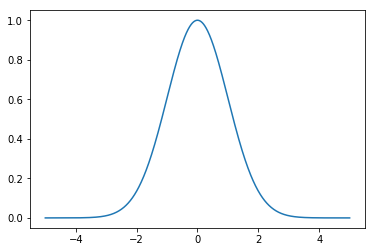

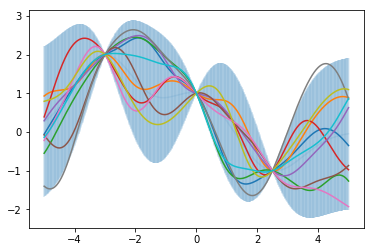

In [330]:
mean,cov, post = noise_free_posterior(squared_exponential_kernel, { "sd": 1., "lengthscale": -1.}, np.array([0]), 20, data, np.array([1]))
plt.plot(data, mean);plt.show()

for i in range(10):
    mean, cov, post = noise_free_posterior(squared_exponential_kernel, { "sd": 1., "lengthscale": -1.}, np.array([-3,0,2.5]), 20, data, np.array([2, 1,-1]))
    plt.plot(data, post.flatten());
plt.errorbar(data, mean, yerr=1.96*np.sqrt(cov.diagonal()), alpha = .1)
plt.show()

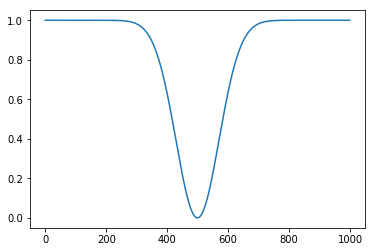

In [303]:
plt.plot(cov.diagonal())

In [284]:
def noisy_posterior(kernel, hyper_params, data, num_realisations, eval_points, target_points, noise = .1):
    
    temp = np.dot(kernel(eval_points, data, **hyper_params), np.linalg.inv(kernel(data, data, **hyper_params) + noise*np.eye(len(data))))
    
    mean = np.dot(temp, target_points.T)
    
    cov = kernel(eval_points, eval_points, **hyper_params) - np.dot(temp, kernel(data, eval_points, **hyper_params))
    
    post=np.random.multivariate_normal(mean.flatten(), cov, 1)
#     covariance = 
    return mean, cov, post


In [285]:
mean, cov, post = noisy_posterior(squared_exponential_kernel, { "sd": 1., "lengthscale": -1.}, np.array([0]), 20, data, np.array([1]))


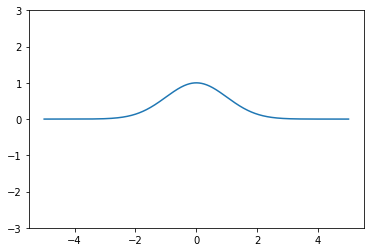

In [291]:
plt.plot(data, mean);
plt.ylim(-3,3)
plt.show()

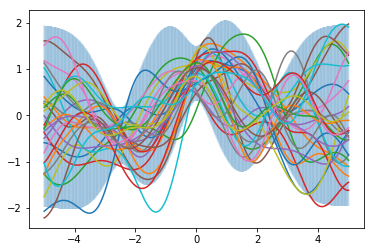

In [324]:
for i in range(30):
    mean, cov, post = noisy_posterior(squared_exponential_kernel, { "sd": 1., "lengthscale": -1.}, np.array([-2.5,0, 2.5]), 20, data, np.array([-.5,1, 0]))
    plt.plot(data, post.flatten());
plt.errorbar(data, mean, yerr=np.sqrt(cov.diagonal())*1.96, alpha = .1)
plt.show()

In [88]:
def acquisition_function(option = "MPI"):
    if option == "MPI":
        pass
    elif option == "EI":
        raise NotImplementedError
    elif option == "LCB":
        raise NotImplementedError

SyntaxError: unexpected EOF while parsing (<ipython-input-88-8caa249f5062>, line 1)

In [313]:
np.stack(cov.diagonal(), -cov.diagonal()).shape

TypeError: only length-1 arrays can be converted to Python scalars

In [315]:
cov.diagonal()

array([ 0.99824224,  0.99815222,  0.99805796,  0.99795932,  0.99785608,
        0.99774808,  0.99763511,  0.99751698,  0.99739346,  0.99726435,
        0.99712941,  0.99698843,  0.99684115,  0.99668734,  0.99652673,
        0.99635907,  0.99618407,  0.99600147,  0.99581097,  0.99561227,
        0.99540507,  0.99518905,  0.99496388,  0.99472922,  0.99448475,
        0.99423008,  0.99396487,  0.99368873,  0.99340128,  0.99310213,
        0.99279085,  0.99246704,  0.99213025,  0.99178006,  0.99141601,
        0.99103763,  0.99064445,  0.99023597,  0.98981171,  0.98937113,
        0.98891373,  0.98843896,  0.98794627,  0.98743511,  0.9869049 ,
        0.98635504,  0.98578495,  0.985194  ,  0.98458158,  0.98394705,
        0.98328975,  0.98260902,  0.98190419,  0.98117457,  0.98041945,
        0.97963812,  0.97882986,  0.97799393,  0.97712958,  0.97623603,
        0.97531253,  0.97435827,  0.97337247,  0.97235431,  0.97130297,
        0.97021762,  0.96909741,  0.9679415 ,  0.96674901,  0.96

In [ ]:
# Last Mile Applications 